### Chest X-ray images 

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

<br>
<hr>


In [1]:
import os 
import glob 
import time
import cv2 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import ConfusionMatrixDisplay


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import InputLayer, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Resnet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions

In [2]:
# set seed 
seed = 42 
np.random.seed(seed)
tf.random.set_seed(seed=seed)

In [3]:
# GPU check 
if tf.test.gpu_device_name():
    print('Default GPU device: {}'.format(tf.test.gpu_device_name()))
else: 
    print('Please install GPU for tensorflow')

Please install GPU for tensorflow


In [4]:
# loading images dataset 

dir_train = "/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/train"
dir_test = "/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/test"
dir_valid = "/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/val"



train_dataset = image_dataset_from_directory(directory=dir_train,
                                             labels='inferred',
                                             class_names=["NORMAL", "PNEUMONIA"],
                                             image_size=(224, 224),
                                             batch_size=32)


test_dataset = image_dataset_from_directory(directory=dir_test,
                                            labels='inferred',
                                            class_names=["NORMAL", "PNEUMONIA"],
                                            image_size=(224, 224),
                                            batch_size=32)




valid_dataset = image_dataset_from_directory(directory=dir_valid,
                                            labels='inferred',
                                            class_names=["NORMAL", "PNEUMONIA"],
                                            image_size=(224, 224),
                                            batch_size=32)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


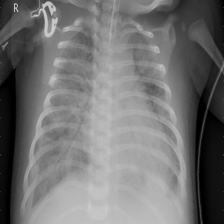

In [5]:
# image size 
img = load_img("/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
img.resize((224, 224))

In [6]:
# class labels 
class_names = train_dataset.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


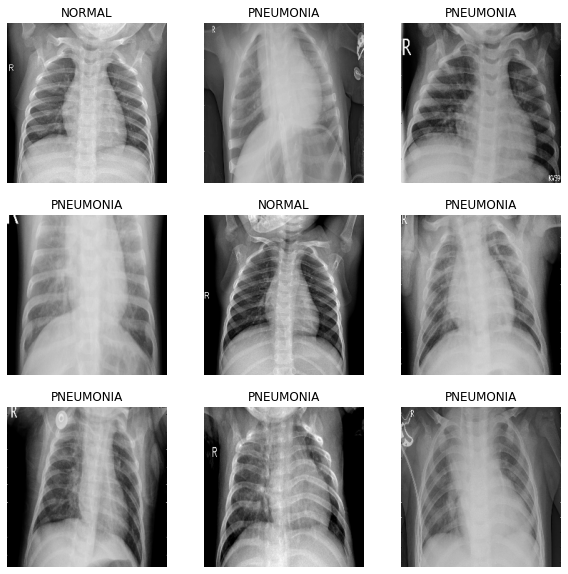

In [7]:
# image samples

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


<br>
<hr>
<br>
<br>

### ResNet50  

<br>

In [ ]:
# preprocessing images 

#%%time
#for image_batch, labels_batch in tqdm(train_dataset, desc="Preprocessing images "):
 # img = preprocess_input(image_batch)
 # print(img)

In [19]:
for image, label in train_dataset.take(1):
  print(image)
  print("-------------------------")
  print('\n')
  img = preprocess_input(image)
  print(img)

tf.Tensor(
[[[[  4.142857     4.142857     4.142857  ]
   [  8.           8.           8.        ]
   [  4.82653      4.82653      4.82653   ]
   ...
   [250.47485    250.47485    250.47485   ]
   [ 82.75187     82.75187     82.75187   ]
   [ 54.765903    54.765903    54.765903  ]]

  [[  4.142857     4.142857     4.142857  ]
   [  8.428572     8.428572     8.428572  ]
   [  6.           6.           6.        ]
   ...
   [ 66.99534     66.99534     66.99534   ]
   [248.07652    248.07652    248.07652   ]
   [ 50.71935     50.71935     50.71935   ]]

  [[  3.           3.           3.        ]
   [  8.           8.           8.        ]
   [  6.           6.           6.        ]
   ...
   [ 53.585117    53.585117    53.585117  ]
   [109.65164    109.65164    109.65164   ]
   [ 52.188435    52.188435    52.188435  ]]

  ...

  [[243.80841    243.80841    243.80841   ]
   [  0.5714288    0.5714288    0.5714288 ]
   [  0.           0.           0.        ]
   ...
   [  0.           0.   

In [7]:
# Resnet
resnet = ResNet50(include_top=False, input_shape=[224, 224, 3], weights='imagenet', classes=2)

In [8]:
# set up layers 
for layers in resnet.layers[:50]:
    layers.trainable=False

In [9]:
# last layer 
resnet.layers[174]

In [10]:
# Resnet50 with fine-tuning 

image = resnet.input
image = preprocess_input(image) # preprocessing image 
input = resnet.output
x = GlobalAveragePooling2D()(input)
output_layer = Dense(1, activation="sigmoid")(x)


model = Model(inputs=resnet.input, outputs=output_layer)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [28]:
# config network 
model.compile(optimizer=Adam(lr=0.001),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


# callbacks 
early_stopper = EarlyStopping(patience=10)
learning_rate_reduction= ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.0001)

In [29]:
%%time 

history = model.fit(train_dataset,  # normalized images
          epochs=30,
          validation_data=test_dataset,
          callbacks=[early_stopper, learning_rate_reduction])

Epoch 1/30
163/163 [==============================] - 84s 463ms/step - loss: 0.1592 - accuracy: 0.9349 - val_loss: 1.3935 - val_accuracy: 0.7179
Epoch 2/30
163/163 [==============================] - 77s 462ms/step - loss: 0.0646 - accuracy: 0.9760 - val_loss: 2.8404 - val_accuracy: 0.6587
Epoch 3/30
163/163 [==============================] - 78s 467ms/step - loss: 0.0365 - accuracy: 0.9865 - val_loss: 2.7303 - val_accuracy: 0.6939

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/30
163/163 [==============================] - 78s 470ms/step - loss: 0.0270 - accuracy: 0.9900 - val_loss: 1.5755 - val_accuracy: 0.7324
Epoch 5/30
163/163 [==============================] - 78s 469ms/step - loss: 0.0089 - accuracy: 0.9966 - val_loss: 1.1875 - val_accuracy: 0.8077
Epoch 6/30
163/163 [==============================] - 78s 467ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 1.9375 - val_accuracy: 0.7660
Epoch 7/30
163/163 [=============================

In [30]:
loss, accuracy = model.evaluate(valid_dataset)

1/1 [==============================] - 0s 160ms/step - loss: 4.8185e-04 - accuracy: 1.0000


In [31]:
# save model 
!mkdir -p /content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/saved_model
model.save('/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/saved_model/resnet_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/saved_model/resnet_model/assets


In [32]:
!ls /content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/saved_model

resnet_model


<br>
<hr>
<br>
<br>

### Evaluate model
<br>

In [13]:
# load model 

new_model = tf.keras.models.load_model('/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/saved_model/resnet_model')

In [14]:
# valid dataset 
new_model.evaluate(valid_dataset)

1/1 [==============================] - 4s 4s/step - loss: 4.8186e-04 - accuracy: 1.0000


[0.000481858296552673, 1.0]

In [18]:
# test dataset 
new_model.evaluate(test_dataset)

 1/20 [>.............................] - ETA: 37:47 - loss: 1.2594 - accuracy: 0.7812

KeyboardInterrupt: ignored

In [15]:
# true class 
y_true = []
for image, label in valid_dataset.take(1):
    y_true.append(label)

y_true = np.array(y_true)
y_true = y_true.reshape(-1, 1)

In [16]:
# prediction 
y_pred = new_model.predict(valid_dataset)
y_pred = np.around(y_pred, decimals=0)

In [21]:
y_true.shape, y_pred.shape

((16, 1), (16, 1))

In [22]:
print(classification_report(y_true, y_pred, target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.50      0.50      0.50         8
   Pneumonia       0.50      0.50      0.50         8

    accuracy                           0.50        16
   macro avg       0.50      0.50      0.50        16
weighted avg       0.50      0.50      0.50        16



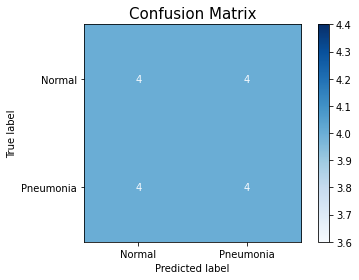

In [23]:
# Confusion matrix 
labels = ["Normal", "Pneumonia"]
mat = confusion_matrix(y_true,y_pred)


cmd = ConfusionMatrixDisplay(mat, display_labels=['Normal', 'Pneumonia'])
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [24]:
# metrics 

acc = accuracy_score(y_true, y_pred)*100

tn, fp, fn, tp = mat.ravel()
print('Test Metrics:')
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

Test Metrics:
Accuracy: 50.0%
Precision: 50.0%
Recall: 50.0%
F1-score: 50.0


<br>
<hr>
<br>
<br>


### Inference 


<br>

In [17]:
def inference(image_path):

    # preprocessing image 
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # prediction 
    y_pred = new_model.predict(x)
    y_pred = np.around(y_pred, decimals=0)
    y_proba = new_model.predict(x)



    if y_pred==1:
      img = load_img(image_path)
      plt.figure(figsize=(8,5))
      plt.imshow(img)
      plt.title("Prediction: Pneumonia")
      plt.show()
      print("Probability:  {}".format(y_proba*100))
    else:
      img = load_img(image_path)
      plt.figure(figsize=(8,5))
      plt.imshow(img)
      plt.title("Prediction: Normal")
      plt.show()
      print("Probability:  {}".format(y_proba*100))

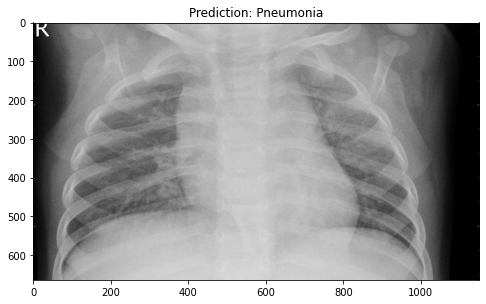

Probability:  [[100.]]


In [18]:
# inference (pneumonia)
inference(image_path='/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/val/PNEUMONIA/person1947_bacteria_4876.jpeg')

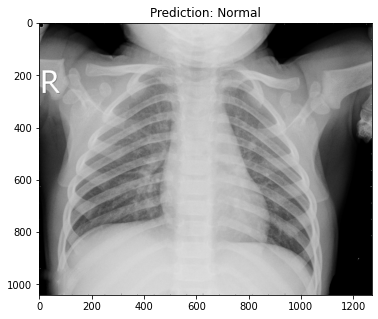

Probability:  [[4.480806]]


In [19]:
# inference (normal)
inference(image_path='/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/val/NORMAL/NORMAL2-IM-1430-0001.jpeg')

In [20]:
# Pneumonia image 

img_path = '/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/val/PNEUMONIA/person1947_bacteria_4876.jpeg'
img = load_img(img_path, target_size=(224, 224))
pneumonia = img_to_array(img)
pneumonia = np.expand_dims(pneumonia, axis=0)
pneumonia = preprocess_input(pneumonia)

<br>
<hr>
<br>

<br>
<hr>
<br>
<br>


### GradCAM interpretability 

Implementation of GradCAM method for Convolutional neural networks.


https://github.com/ismailuddin/gradcam-tensorflow-2/blob/master/notebooks/GradCam.ipynb

<br>

In [21]:
# last convolutional layer 

last_conv_layer_name = "conv5_block3_out"

classifier_layer_names = [
    "global_average_pooling2d",
    "dense "]


# image 
img_path = "/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/test/PNEUMONIA/person100_bacteria_479.jpeg"
img = load_img(img_path, target_size=(224, 224))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

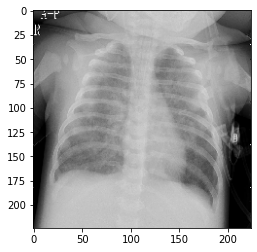

In [65]:
image = np.array(load_img("/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/val/PNEUMONIA/person1952_bacteria_4883.jpeg", target_size=(224, 224, 3)))
plt.imshow(image)

In [60]:
image.shape

(224, 224, 3)

In [61]:
model = ResNet50()

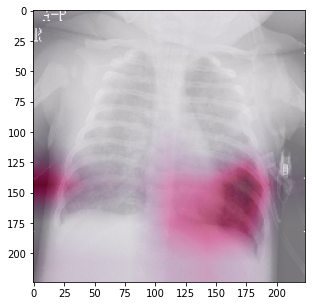

In [66]:
# GradCAM 

last_conv_layer = model.get_layer("conv5_block3_out")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)


classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["avg_pool", "predictions"]:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)



with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]


    
grads = tape.gradient(top_class_channel, last_conv_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]



# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (224, 224))


plt.figure(figsize=(10,5))
plt.imshow(image)
plt.imshow(gradcam, alpha=0.5, cmap="PuRd")
plt.show()

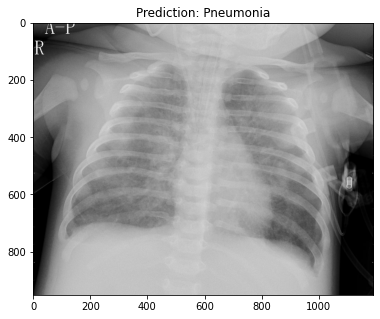

Probability:  [[100.]]


In [67]:
inference(image_path="/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/val/PNEUMONIA/person1952_bacteria_4883.jpeg")